In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [3]:
# Load the dataset
file_path = r"C:\Users\neels\Downloads\movies.csv\movies.csv"  # Adjust path as needed
df = pd.read_csv(file_path)

In [5]:
# Data Cleaning
df = df.dropna(subset=['genres', 'title'])
df['genres'] = df['genres'].str.lower().str.replace(' ', '')

In [7]:
# Train-Test Split
# Train-Test Split with reset index
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)  # Reset indices to match matrix rows

In [9]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english')
genre_matrix_train = vectorizer.fit_transform(df_train['genres'])
genre_matrix_test = vectorizer.transform(df_test['genres'])

In [11]:
# Train Nearest Neighbors model
nn_model = NearestNeighbors(metric='cosine', algorithm='brute')
nn_model.fit(genre_matrix_train)

NearestNeighbors(algorithm='brute', metric='cosine')

C:\Users\neels\AppData\Local\Temp\ipykernel_19156\3853324474.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')


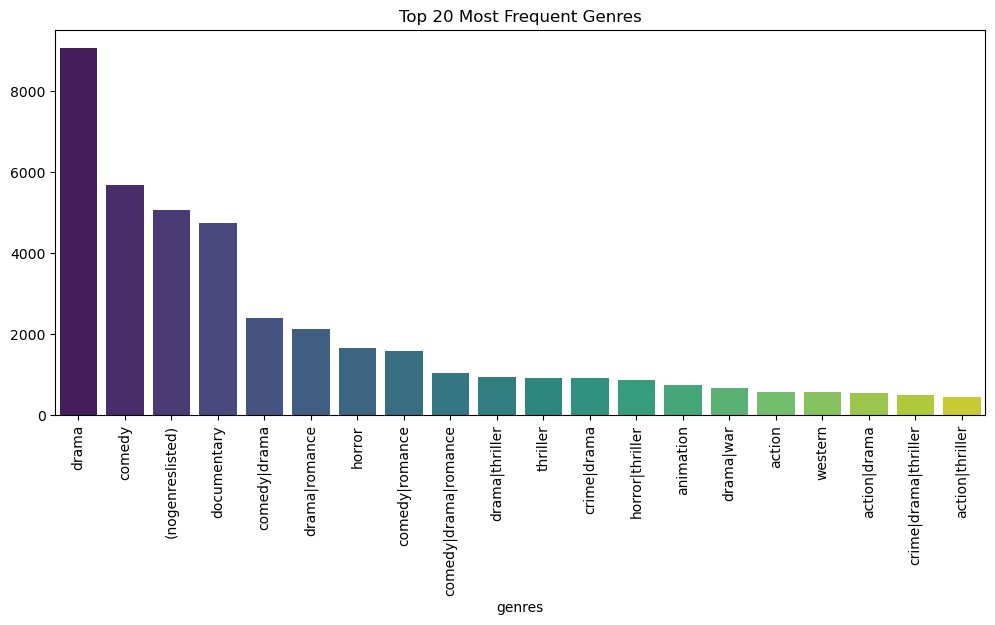

In [13]:
# Data Visualization - Genre Distribution
plt.figure(figsize=(12, 5))
genre_counts = df['genres'].value_counts().nlargest(20)
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.xticks(rotation=90)
plt.title("Top 20 Most Frequent Genres")
plt.show()

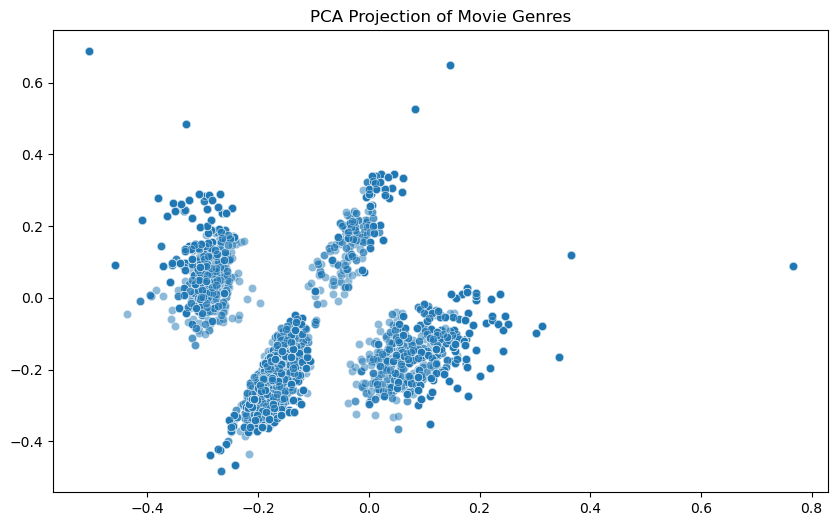

In [15]:
# PCA Visualization of Genre Space
pca = PCA(n_components=2)
pca_result = pca.fit_transform(genre_matrix_train.toarray())
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], alpha=0.5)
plt.title("PCA Projection of Movie Genres")
plt.show()

In [17]:
# Movie Recommendation Function (for movies in the training set)
def recommend_movies_nn(movie_title, df, nn_model, genre_matrix, top_n=10):
    # Check for exact match first
    exact_match = df[df['title'].str.lower() == movie_title.lower().strip()]
    if not exact_match.empty:
        movie_index = exact_match.index[0]
    else:
        # Fallback to contains match
        contains_matches = df[df['title'].str.contains(movie_title, case=False, na=False, regex=False)]
        if contains_matches.empty:
            return []
        movie_index = contains_matches.index[0]
    
    # Find nearest neighbors
    distances, indices = nn_model.kneighbors(genre_matrix[movie_index], n_neighbors=top_n+1)
    # Exclude the movie itself if present
    if indices[0][0] == movie_index:
        recommended_indices = indices[0][1:top_n+1]
    else:
        recommended_indices = indices[0][:top_n]
    recommended_movies = df.iloc[recommended_indices]['title'].tolist()
    return recommended_movies

In [19]:
# Evaluation Metrics
def precision_at_k(recommended, relevant, k=10):
    return len(set(recommended[:k]) & set(relevant)) / k

def recall_at_k(recommended, relevant, k=10):
    return len(set(recommended[:k]) & set(relevant)) / len(relevant) if relevant else 0

def f1_score_at_k(precision, recall):
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

def ndcg_at_k(recommended, relevant, k=10):
    if not recommended:
        return 0
    dcg = sum([1 / np.log2(i + 2) if rec in relevant else 0 for i, rec in enumerate(recommended[:k])])
    idcg = sum([1 / np.log2(i + 2) for i in range(min(len(relevant), k))])
    return dcg / idcg if idcg > 0 else 0

def hit_rate(recommended, relevant):
    return 1 if set(recommended) & set(relevant) else 0

In [21]:
# Revised Evaluation Function
def evaluate_recommendations(df_test, df_train, nn_model, genre_matrix_test, k=10, sample_size=100):
    sampled_indices = df_test.sample(n=min(sample_size, len(df_test))).index.tolist()
    precision_scores, recall_scores, f1_scores, ndcg_scores, hit_scores = [], [], [], [], []
    
    for test_idx in sampled_indices:
        test_genre = df_test.loc[test_idx, 'genres']
        test_vector = genre_matrix_test[test_idx]
        # Find nearest neighbors in training set
        distances, indices = nn_model.kneighbors(test_vector.reshape(1, -1), n_neighbors=k)
        recommended = df_train.iloc[indices[0]]['title'].tolist()
        # Get relevant movies (exact genre match in train)
        relevant = df_train[df_train['genres'] == test_genre]['title'].tolist()
        
        precision = precision_at_k(recommended, relevant, k)
        recall = recall_at_k(recommended, relevant, k)
        f1 = f1_score_at_k(precision, recall)
        ndcg = ndcg_at_k(recommended, relevant, k)
        hit = hit_rate(recommended, relevant)
        
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        ndcg_scores.append(ndcg)
        hit_scores.append(hit)
    
    return {
        "Precision@K": np.mean(precision_scores),
        "Recall@K": np.mean(recall_scores),
        "F1-Score": np.mean(f1_scores),
        "NDCG": np.mean(ndcg_scores),
        "Hit Rate": np.mean(hit_scores)
    }


In [25]:
# Example Recommendation
print("Recommendations for 'Inception':")
print(recommend_movies_nn("Inception", df_train, nn_model, genre_matrix_train))

Recommendations for 'Inception':
['Watchmen (2009)', 'Super 8 (2011)', 'RoboCop (2014)', 'Transformers (2007)', 'Battleship (2012)', 'Riddick (2013)', 'V for Vendetta (2006)', 'Iron Man 3 (2013)', 'I Am Number Four (2011)', 'Real Steel (2011)']


In [27]:
# Example Recommendation
print("Recommendations for 'Inception':")
print(recommend_movies_nn("Inception", df_train, nn_model, genre_matrix_train))

# Example Evaluation on Test Set
print("\nEvaluation Results:")
evaluation_results = evaluate_recommendations(df_test, df_train, nn_model, genre_matrix_test)
for metric, value in evaluation_results.items():
    print(f"{metric}: {value:.4f}")

Recommendations for 'Inception':
['Watchmen (2009)', 'Super 8 (2011)', 'RoboCop (2014)', 'Transformers (2007)', 'Battleship (2012)', 'Riddick (2013)', 'V for Vendetta (2006)', 'Iron Man 3 (2013)', 'I Am Number Four (2011)', 'Real Steel (2011)']

Evaluation Results:
Precision@K: 0.9620
Recall@K: 0.0842
F1-Score: 0.1008
NDCG: 0.9800
Hit Rate: 0.9800
